In [1]:
__author__ = 'Hazar Panc'
__email__ = 'hello@hazarpanc.com'
__website__ = 'www.hazarpanc.com'

In [3]:
import pandas as pd
import numpy as np
import os
import gc
import warnings
from google.colab import drive
warnings.filterwarnings("ignore")

drive.mount('drive') # , force_remount=True

Drive already mounted at drive; to attempt to forcibly remount, call drive.mount("drive", force_remount=True).


## Load and display data

In [4]:
def import_data(file):
    """create a dataframe and load csv file"""
    df = pd.read_csv(file, index_col=0)
    return df

In [5]:
filepath = "drive/MyDrive/Colab Notebooks/Portfolio/train.csv"
df = import_data(filepath)

In [6]:
df

,make,model,odometer,price,bodytype,status,trim,year,vehicleAge,drivetrain,transmission,description,province
1399,Audi,S5,"145,396 KM","30,999",coupe,Used,2dr Cpe Auto Progressiv -Ltd Avail-,2016,NaN,AWD,Automatic,"Traction intégrale, système de navigation, toi...",quebec
1400,Audi,Q3,"20,443 KM","33,499",suv,Used,2.0 TFSI quattro Komfort Tiptronic,2018,NaN,AWD,Automatic,"Traction intégrale, toit panoramique, sièges c...",quebec
1401,Audi,A4,"108,716 KM","14,495",sedan,Used,PREMIUM PLUS QUATTRO NAV CUIR TOIT CAM DE RECU...,2013,NaN,AWD,Automatic,***FINANCEMENT RAPIDE ET FACILE | APPROBATION ...,quebec
1407,Audi,S6,"213,077 KM","20,890",sedan,Used,NaN,2013,NaN,AWD,Automatic,- 1 seul propriétaire mature depuis neuf\n\n- ...,quebec
1412,Audi,A4,"148,477 KM","13,989",sedan,Used,PREMIUM PLUS S-LINE QUATTRO + WOW !!,2013,NaN,AWD,Manual,"* * MANUELLE RARE, WOW FAITES-VITE !! * * \n\n...",quebec
...,...,...,...,...,...,...,...,...,...,...,...,...,...
67864,Volvo,Xc60,"31,678 KM","65,990",suv,Used,*HYBRID*PRICED TO SELL*WARRANTY UNTIL 160K*0.99%,2020,NaN,AWD,8 Speed Automatic,"VOLVO WARRANTY UNTIL DECEMBER 2026 OR 160,000K...",ontario
67865,Volvo,Xc60,"43,124 KM","45,999",suv,Used,"T6 Momentum - warranty till 2024 /160,000km",2019,NaN,AWD,8 Speed Automatic,Black 2019 Volvo XC60 T6 Momentum AWD Automati...,ontario
67866,Volvo,Xc60,"27,371 KM","52,900",suv,Used,T6 AWD Momentum,2020,NaN,AWD,8 Speed Automatic,"CPO Warranty until April 2026 or 160,000km. C...",ontario
67867,Volvo,Xc40,"40,377 KM","39,551",suv,Used,MOMENTUM | ONE OWNER | NO ACCIDENT,2019,NaN,AWD,8 Speed Automatic,CARFAX Canada No Reported Accidents\nCARFAX Ca...,ontario


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 54761 entries, 1399 to 67868
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   make          54761 non-null  object 
 1   model         54761 non-null  object 
 2   odometer      54557 non-null  object 
 3   price         54759 non-null  object 
 4   bodytype      54023 non-null  object 
 5   status        54761 non-null  object 
 6   trim          52575 non-null  object 
 7   year          54761 non-null  int64  
 8   vehicleAge    0 non-null      float64
 9   drivetrain    53346 non-null  object 
 10  transmission  53191 non-null  object 
 11  description   49854 non-null  object 
 12  province      54680 non-null  object 
dtypes: float64(1), int64(1), object(11)
memory usage: 5.8+ MB


# Data Preprocessing

Drop columns that doesn't contain useful informaton
- All of the values in the status column is the same: "Used"
- vehicleAge column contains only null values
- description column contains long text data that dealers wrote for the listing. We are not planning to use text data at this stage.

In [8]:
df.status.value_counts()

Used    54761
Name: status, dtype: int64

In [9]:
df.drop(['description','status','vehicleAge'],axis=1,inplace=True)

## Clean Columns

In order to get the data to a format that we can use in our analysis and models we will clean the columns one by one and fix data types.

In [10]:
def clean_model_col(df):
    ''' Cleans the model column of a dataframe. Accepts and returns pandas dataframe.'''
    
    # Model names in the data are in different cases, which might cause duplicate data. 
    # We will convert them to proper case (title)
    df['model'] = df['model'].apply(lambda x: str(x).title())

    # Convert French variations of some model names to English (e.g. Mini Cooper 5 Door - Mini Cooper 5 Portes) 
    df['model'] = df['model'].apply(lambda x: x.replace("Portes","Door"))

    # If a model name recurs in data fewer times than a threshold, remove that model from data to avoid overfitting
    model_threshold = 3
    valid_models_list = list(df['model'].value_counts()[df['model'].value_counts()>model_threshold].index)
    df['model'] =  df['model'].apply(lambda x: x if x in valid_models_list else np.nan)

    # Remove rows where model name is "other/unspecified", as those records won't be useful for our model
    df['model'] = df['model'].replace('Other/Unspecified', np.nan)

    # Remove NAs
    df.dropna(subset=['model'],inplace=True)
    
    return df

In [11]:
def clean_trim_col(df):
    ''' Cleans the trim column of a dataframe. Accepts and returns pandas dataframe.'''
    
    def clean_trim_string(trim):
        trim = str(trim)
        
        # Fix entries such as "Actual trim of the car + seperator + car features
        # Example: "T6 AWD | HEATED SEATS | REVERSE CAMERA | NAVIGATION "
        
        # Get the text before any seperators. Convert it to titlecase for standardization
        trim = trim.split(' ')[0].title()
        trim = trim.split('|')[0].title()
        trim = trim.split(',')[0].title()

        # Replace any French names with English
        trim = trim.replace('Coupé','Coupe')
        trim = trim.replace('Hybride','Hybrid')
        trim = trim.replace('Essentiel','Base')
        trim = trim.replace('4Matic&#174;','4Matic')

        # Remove any special characters
        trim = trim.replace('!','')
        trim = trim.replace('*','')
        trim = trim.replace('/','')

        # Now we should have a clean trim 
        # There are some names that are entered into the trim field. But they are not actual trims (e.g. Low kilometers, certified). 
        # Replace these trim values with nan
        invalid_trims = ["Nan","-","|","Low","No","W","*","New","Familiale","Manuelle","Certified","Delivered","Excellent","Automatique","Apple","Local","Camera","Awd","Nouvel","Backup","Unknown","Pano","Panoramic","Remote","Recent","Incoming",'Modèle', 'Bmw', 'Nav', 'Fwd', 'Commodité', 'Just','5Dr','4Dr','2Dr','Ensemble','Vdpurlen','4X4','4Wd','2Wd','Édition','Cuir','Navi','Toit','Only','One','Auto','Power','As','AC','Rwd','Traction','Auto']
        if trim in invalid_trims:
            trim = 'nan'

        invalid_words = ["owner","heated","certified","navigation","sold","vendu","manual","manuel","accident","loaded","clean","mint","garantie","sunroof","nouvel","gps","leather","garantie","réservé","reserve","jamais","local","excellent","rare","bluetooth","full"]
        for word in invalid_words:
            if word in trim.lower():
                trim = 'nan'

        # Another pattern that we see in data is that some users entered the model year of the car as trim. 
        # Replace those with nan
        try:
            numeric_trim = int(trim)
            if numeric_trim > 2000 and numeric_trim <2025:
                trim = 'nan'
        except:
            pass

        if trim == "":
            trim = 'nan'

        return trim

    df['trim'] = df['trim'].apply(lambda x: clean_trim_string(x))

    # As the same trim names can be found in different makes and this can reduce the performance of ML algorithms, we combine the trim name with the manufacturer name 
    df['trim'] = df.apply(lambda row: row['model'] + "-" + row['trim'] ,axis=1)

    # Fix some errorenous entries
    df['trim'] = df['trim'].apply(lambda x: "nan" if "-nan" in x else x)

    # We will only use trim values that recur in data at least "n" times to avoid overfitting. 
    # n is specified by the threshold variable
    trim_treshold = 5
    popular_trims = df['trim'].value_counts()[df['trim'].value_counts()>trim_treshold].index
    df['trim'] =  df['trim'].apply(lambda x: x if x in popular_trims else 'nan')

    # Replace np.nan trims with string 'nan'
    df['trim'].fillna('nan', inplace = True)
    
    return df

In [12]:
def clean_transmission_col(df):
    ''' Cleans the transmission column of a dataframe. Accepts and returns pandas dataframe.'''
    
    # Convert transmission column to a binary column for manual transmission
    # Value of 1 indicates that the car has manual transmission
    df['transmission_manual'] = df['transmission'].apply(lambda x: 1 if x == "Manual" else 0)
    df.drop('transmission',axis=1,inplace=True)
    
    return df

In [13]:
def clean_drivetrain_col(df):
    ''' Cleans the drivetrain column of a dataframe. Accepts and returns pandas dataframe.'''
    
    # Map various values to standardized values of AWD, FWD or RWD
    drivetrain_mapping = {"4x4": "AWD","4X4":"AWD", "4WD":"AWD", "2WD":"FWD","Not Available":"AWD"}
    df['drivetrain'] = df['drivetrain'].replace(drivetrain_mapping)
    df['drivetrain'].fillna('AWD',inplace=True)
    
    return df

In [14]:
def clean_bodytype_col(df):
    ''' Cleans the bodytype column of a dataframe. Accepts and returns pandas dataframe.'''
    
    # Map various values to one of the following standardized values: 
    # truck, station wagon, minivan, convertible, sedan, hatchback
    df['bodytype'] = df['bodytype'].apply(lambda x: "truck" if ("truck" in str(x)) else x)
    df['bodytype'] = df['bodytype'].apply(lambda x: "truck" if ("cab " in str(x)) else x)
    df['bodytype'] = df['bodytype'].apply(lambda x: "truck" if (" cab" in str(x)) else x)
    df['bodytype'] = df['bodytype'].apply(lambda x: "truck" if ("super crew" in str(x)) else x)
    df['bodytype'] = df['bodytype'].apply(lambda x: "station wagon" if ("wagon" in str(x)) else x)
    df['bodytype'] = df['bodytype'].apply(lambda x: "minivan" if ("van" in str(x)) else x)
    df['bodytype'] = df['bodytype'].apply(lambda x: "convertible" if ("cabriolet" in str(x)) else x)
    df['bodytype'] = df['bodytype'].apply(lambda x: "convertible" if ("roadster" in str(x)) else x)
    df['bodytype'] = df['bodytype'].apply(lambda x: "hatchback" if ("compact" in str(x)) else x)
    df['bodytype'] = df['bodytype'].apply(lambda x: "sedan" if ("cutaway" in str(x)) else x)
    
    return df

In [15]:
def clean_odometer_col(df):
    ''' Cleans the odometer column of a dataframe. Accepts and returns pandas dataframe.'''
    
    def clean_odometer_value(odometer_value):
        ''' Takes an odometer string. Cleans it of any characters and returns the integer value of odometer'''
        odometer_str = str(odometer_value)
        odometer_str = odometer_str.replace(" KM","")
        odometer_str = odometer_str.replace(",","")

        try:
            odometer_int = int(odometer_str)
        except:
            odometer_int = np.nan

        return odometer_int

    df['odometer'] = df['odometer'].apply(lambda x: clean_odometer_value(x))


    # We will consider listings of cars that are 'older than 2 years old' AND 'have less than 1000 kilometers' as outliers
    # Remove those from data
    df['odometer_invalid'] = 0
    df.loc[(df['year']<=2020) & (df['odometer']<1000),'odometer_invalid']= 1
    df = df[df['odometer_invalid']== 0]
    df.drop('odometer_invalid',axis=1,inplace=True)
    
    return df

In [16]:
def clean_price_col(df):
    
    
    # Drop any rows which have nan as price. Since price is our target column, they won't add any value.
    df.dropna(subset=['price'],inplace=True)
    
    # Clean the price value and convert from string to integer
    df['price'] = df['price'].apply(lambda x: str(x).replace(",",""))
    df['price'] = df['price'].apply(lambda x: int(x))
    
    return df

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 54761 entries, 1399 to 67868
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   make          54761 non-null  object
 1   model         54761 non-null  object
 2   odometer      54557 non-null  object
 3   price         54759 non-null  object
 4   bodytype      54023 non-null  object
 5   trim          52575 non-null  object
 6   year          54761 non-null  int64 
 7   drivetrain    53346 non-null  object
 8   transmission  53191 non-null  object
 9   province      54680 non-null  object
dtypes: int64(1), object(9)
memory usage: 4.6+ MB


In [18]:
# Apply the cleaning functions to the dataframe
for func in [clean_model_col, clean_trim_col, clean_transmission_col, clean_drivetrain_col,clean_bodytype_col, 
             clean_odometer_col, clean_price_col]:
    df = func(df)

# Filter out unreasonable values for price, year and odometer
df = df[df['price']<250000]
df = df[df['year']<=2022]
df = df[df['odometer']<=290000]

# Convert the datatype of numerical columns from object to int
df = df.astype({"odometer": int,"price":int,'transmission_manual':int,'year':int})

# Drop any NA values from df
df.dropna(inplace=True)

# Drop duplicates
df.drop_duplicates(inplace=True)

In [19]:
df

,make,model,odometer,price,bodytype,trim,year,drivetrain,province,transmission_manual
1399,Audi,S5,145396,30999,coupe,nan,2016,AWD,quebec,0
1400,Audi,Q3,20443,33499,suv,Q3-2.0,2018,AWD,quebec,0
1401,Audi,A4,108716,14495,sedan,A4-Premium,2013,AWD,quebec,0
1407,Audi,S6,213077,20890,sedan,nan,2013,AWD,quebec,0
1412,Audi,A4,148477,13989,sedan,A4-Premium,2013,AWD,quebec,1
...,...,...,...,...,...,...,...,...,...,...
67864,Volvo,Xc60,31678,65990,suv,nan,2020,AWD,ontario,0
67865,Volvo,Xc60,43124,45999,suv,Xc60-T6,2019,AWD,ontario,0
67866,Volvo,Xc60,27371,52900,suv,Xc60-T6,2020,AWD,ontario,0
67867,Volvo,Xc40,40377,39551,suv,Xc40-Momentum,2019,AWD,ontario,0


# EDA

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns

### Examine the clean data

In [21]:
df.head(10)

,make,model,odometer,price,bodytype,trim,year,drivetrain,province,transmission_manual
1399,Audi,S5,145396,30999,coupe,nan,2016,AWD,quebec,0
1400,Audi,Q3,20443,33499,suv,Q3-2.0,2018,AWD,quebec,0
1401,Audi,A4,108716,14495,sedan,A4-Premium,2013,AWD,quebec,0
1407,Audi,S6,213077,20890,sedan,nan,2013,AWD,quebec,0
1412,Audi,A4,148477,13989,sedan,A4-Premium,2013,AWD,quebec,1
1419,Audi,A5,64220,41000,coupe,A5-2.0,2018,AWD,ontario,0
1423,Audi,A5,58257,29611,coupe,A5-2.0T,2016,AWD,ontario,0
1431,Audi,Q5,134575,25000,suv,Q5-2.0T,2016,AWD,ontario,0
1437,Audi,Q7,116964,41800,suv,Q7-3.0T,2017,AWD,ontario,0
1438,Audi,A6,53075,35800,sedan,nan,2017,AWD,ontario,0


### Examine length and dtypes

In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 52790 entries, 1399 to 67868
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   make                 52790 non-null  object
 1   model                52790 non-null  object
 2   odometer             52790 non-null  int64 
 3   price                52790 non-null  int64 
 4   bodytype             52790 non-null  object
 5   trim                 52790 non-null  object
 6   year                 52790 non-null  int64 
 7   drivetrain           52790 non-null  object
 8   province             52790 non-null  object
 9   transmission_manual  52790 non-null  int64 
dtypes: int64(4), object(6)
memory usage: 4.4+ MB


In [23]:
# Check for duplicated columns
df.duplicated().sum()

0

### Identify numerical and categorical variables

In [24]:
df.columns

Index(['make', 'model', 'odometer', 'price', 'bodytype', 'trim', 'year',
       'drivetrain', 'province', 'transmission_manual'],
      dtype='object')

In [25]:
numeric_cols = ['odometer', 'price', 'year', 'transmission_manual']

In [26]:
categorical_cols = ['make', 'model', 'bodytype', 'trim', 'drivetrain', 'province']

### Summarize numerical and categorical variables separately

In [27]:
df.describe(include = [np.number])

,odometer,price,year,transmission_manual
count,52790.000000,52790.000000,52790.000000,52790.000000
mean,73793.561413,37836.812105,2017.656090,0.038435
std,49459.643716,24950.307572,2.392192,0.192247
min,0.000000,2000.000000,2012.000000,0.000000
25%,36137.000000,22800.000000,2016.000000,0.000000
50%,64397.500000,32373.500000,2018.000000,0.000000
75%,102351.500000,45325.500000,2019.000000,0.000000
max,290000.000000,249995.000000,2022.000000,1.000000


In [28]:
df.describe(include = ['O'])

,make,model,bodytype,trim,drivetrain,province
count,52790,52790,52790,52790,52790,52790
unique,27,491,8,1171,3,2
top,Honda,Silverado 1500,suv,nan,AWD,ontario
freq,2646,2047,25185,17857,37025,29534


### Visualize target variable (price)

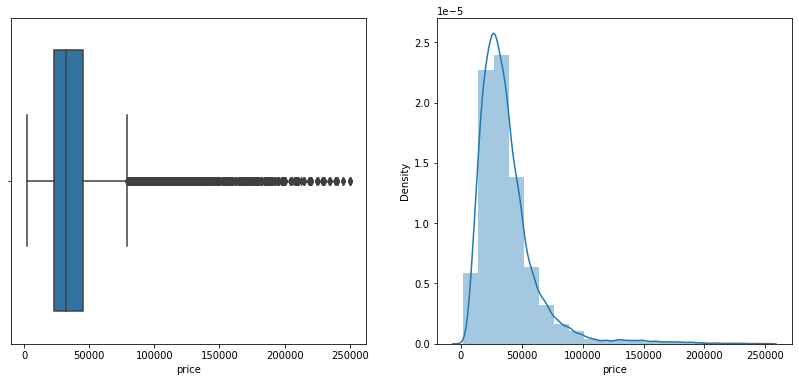

In [29]:
plt.figure(figsize = (14, 6))
plt.subplot(1,2,1)
sns.boxplot(df.price)
plt.subplot(1,2,2)
sns.distplot(df.price, bins=20)
plt.show()

### Use IQR to identify potential outliers

In [30]:
stat = df.price.describe()
print(stat)
IQR = stat['75%'] - stat['25%']
upper = stat['75%'] + 1.5 * IQR
lower = stat['25%'] - 1.5 * IQR
print('The upper and lower bounds for suspected outliers are {} and {}.'.format(upper, lower))

count     52790.000000
mean      37836.812105
std       24950.307572
min        2000.000000
25%       22800.000000
50%       32373.500000
75%       45325.500000
max      249995.000000
Name: price, dtype: float64
The upper and lower bounds for suspected outliers are 79113.75 and -10988.25.


In [31]:
#check potential outlier above upper bound
df.loc[df.price > 79078, 'model'].value_counts()

911                   286
Cayenne               191
Escalade              137
Model Y               131
Corvette              100
                     ... 
Ct5                     1
E-Series Cutaway        1
Silverado 3500          1
Silverado 1500 Ltd      1
Tt                      1
Name: model, Length: 143, dtype: int64

The high-priced potential outliers all are expensive car models. We determine these entries to be legitimate and will not remove them.

In [32]:
def plot_feature(df, col):
    '''
    Make plot for each features
    left, the distribution of samples on the feature
    right, the dependance of price on the feature
    '''
    plt.figure(figsize = (14, 6))
    plt.subplot(1, 2, 1)
    if df[col].dtype == 'int64' or df[col].dtype == 'int32':
        df[col].value_counts().sort_index().plot()
    else:
        #change the categorical variable to category type and order their level by the mean price
        #in each category
        mean = df.groupby(col)['price'].mean()
        df[col] = df[col].astype('category')
        levels = mean.sort_values().index.tolist()
        df[col].cat.reorder_categories(levels, inplace=True)
        df[col].value_counts().plot()
    plt.xticks(rotation=45)
    plt.xlabel(col)
    plt.ylabel('Counts')
    plt.subplot(1, 2, 2)
    
    if df[col].dtype == 'int64' or df[col].dtype == 'int32':
        #plot the mean price for each category and fill between the (mean - std, mean + std)
        mean = df.groupby(col)['price'].mean()
        std = df.groupby(col)['price'].std()
        mean.plot()
        plt.fill_between(range(len(std.index)), mean.values-std.values, mean.values + std.values, \
                         alpha = 0.1)
    else:
        sns.boxplot(x = col, y = 'price', data=df)
    
    plt.xticks(rotation=45)
    plt.ylabel('Price')
    plt.show()

**As expected, luxury brands like Porsche have a higher price, and cheaper brands such as Hyundai, Mitsubishi are on the lower end**

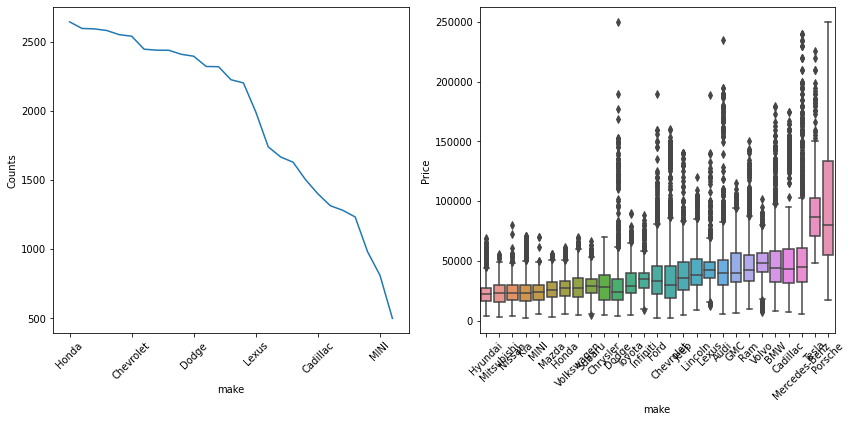

In [33]:
plot_feature(df, 'make')

#### Majority of the listings are for SUVs. Convertible and coupe cars are the most expensive, whereas, hatchback and sedan are the least expensive

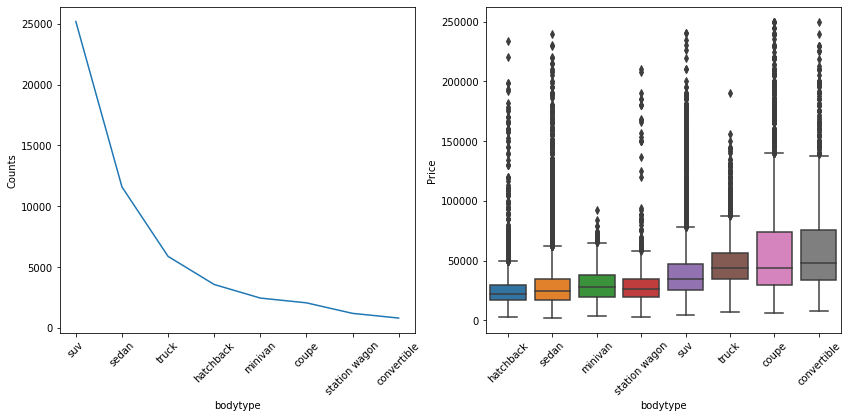

In [34]:
plot_feature(df, 'bodytype')

#### Rear-Wheel Drive cars are the most expensive; Forward-Wheel Drive cars are the least expensive

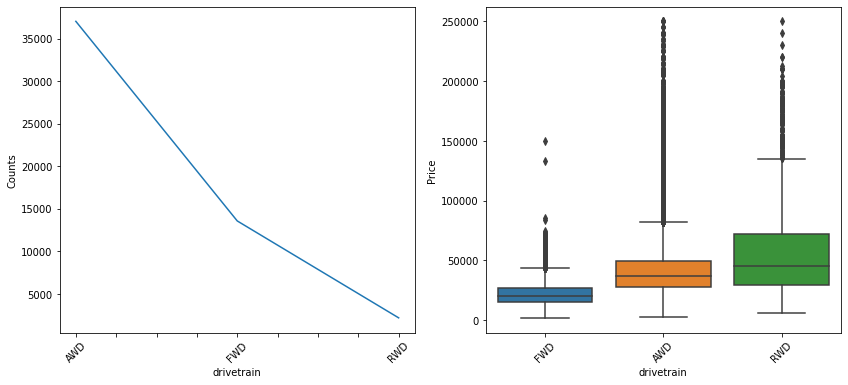

In [35]:
plot_feature(df, 'drivetrain')

#### While we can't be certain just from this graph, prices in Quebec seem to be slightly cheaper than Ontario

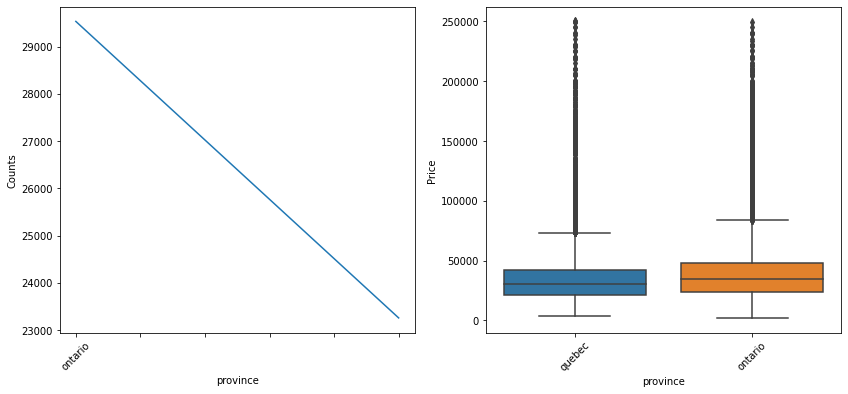

In [36]:
plot_feature(df, 'province')

**There is a clear negative correlation between mileage and price. Cars with higher mileage sell for a lower price**

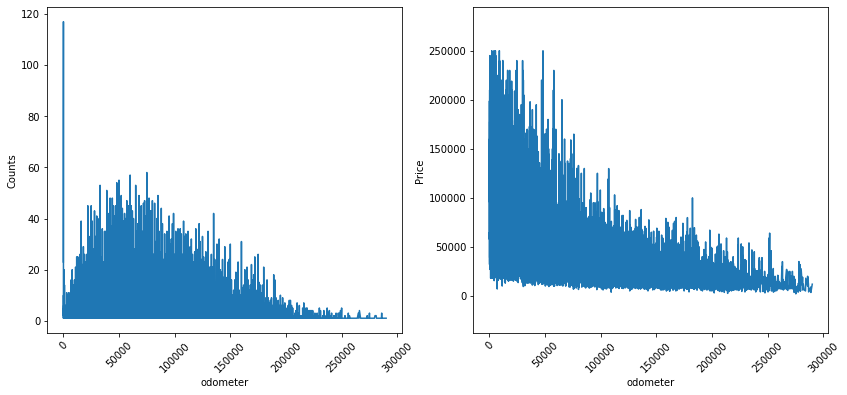

In [37]:
plot_feature(df, 'odometer')

**There is a positive correlation between car year and price.**

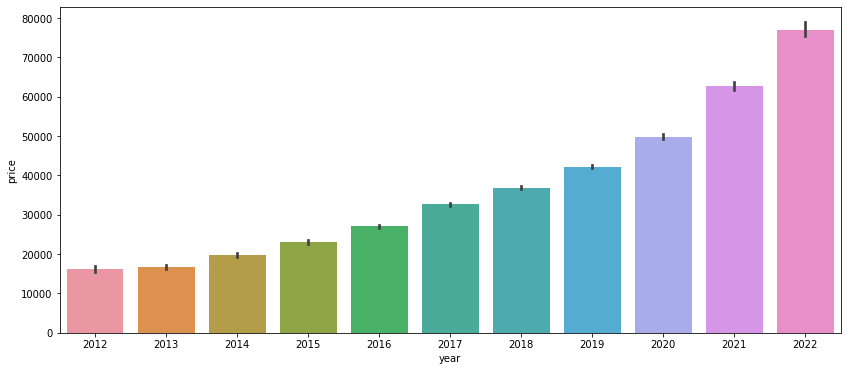

In [38]:
plt.figure(figsize = (14, 6))
sns.barplot(x="year", y="price", data=df)
plt.show()

In [39]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 52790 entries, 1399 to 67868
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype   
---  ------               --------------  -----   
 0   make                 52790 non-null  category
 1   model                52790 non-null  object  
 2   odometer             52790 non-null  int64   
 3   price                52790 non-null  int64   
 4   bodytype             52790 non-null  category
 5   trim                 52790 non-null  object  
 6   year                 52790 non-null  int64   
 7   drivetrain           52790 non-null  category
 8   province             52790 non-null  category
 9   transmission_manual  52790 non-null  int64   
dtypes: category(4), int64(4), object(2)
memory usage: 5.0+ MB


In [40]:
def encode_label(df, col):
    #encode the categories using average price for each category to replace label
    cat_dict ={}
    cats = df[col].cat.categories.tolist()
    for cat in cats:
        cat_dict[cat] = df[df[col] == cat]['price'].mean()   
    df[col] = df[col].map(cat_dict)
    
# Create a temporary dataframe since we will be changing the datatypes and applying encoding
temp_df = df.copy()
    
# Loop through categorical columns and target encode them
for col in categorical_cols:
    # Transform to category
    temp_df[col] = temp_df[col].astype('category')
    encode_label(temp_df, col)
    temp_df[col] = temp_df[col].astype('int32')

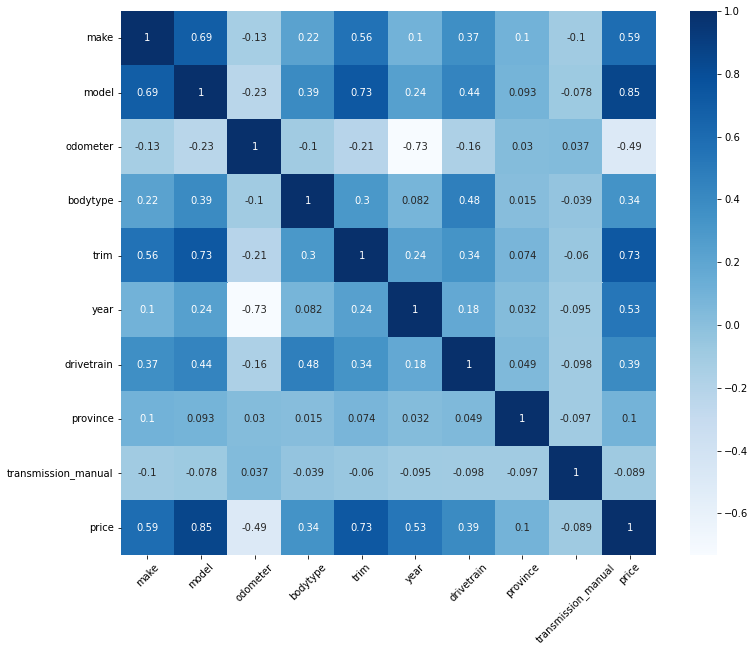

In [41]:
# Correlations between selected features and response
fig = plt.figure(figsize=(12, 10))
features = ['make', 'model', 'odometer', 'bodytype', 'trim', 'year', 'drivetrain', 'province', 'transmission_manual']
sns.heatmap(temp_df[features + ['price']].corr(), cmap='Blues', annot=True)
plt.xticks(rotation=45)
plt.show()

We see that model is most strongly correlated with price, followed by trim, make, year and odometer<br><br>
Among the features, we see that the following feature pairs have a strong degree of correlation:
- odometer and year
- make and model 
- model and trim



In [42]:
# Delete temporary dataframe we had created, to free memory
del temp_df

# Convert category columns back into object
for col in ['make', 'model', 'bodytype', 'trim','drivetrain','province']:
    df[col] = df[col].astype('object')

In [43]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 52790 entries, 1399 to 67868
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   make                 52790 non-null  object
 1   model                52790 non-null  object
 2   odometer             52790 non-null  int64 
 3   price                52790 non-null  int64 
 4   bodytype             52790 non-null  object
 5   trim                 52790 non-null  object
 6   year                 52790 non-null  int64 
 7   drivetrain           52790 non-null  object
 8   province             52790 non-null  object
 9   transmission_manual  52790 non-null  int64 
dtypes: int64(4), object(6)
memory usage: 6.4+ MB


In [44]:
df

,make,model,odometer,price,bodytype,trim,year,drivetrain,province,transmission_manual
1399,Audi,S5,145396,30999,coupe,nan,2016,AWD,quebec,0
1400,Audi,Q3,20443,33499,suv,Q3-2.0,2018,AWD,quebec,0
1401,Audi,A4,108716,14495,sedan,A4-Premium,2013,AWD,quebec,0
1407,Audi,S6,213077,20890,sedan,nan,2013,AWD,quebec,0
1412,Audi,A4,148477,13989,sedan,A4-Premium,2013,AWD,quebec,1
...,...,...,...,...,...,...,...,...,...,...
67864,Volvo,Xc60,31678,65990,suv,nan,2020,AWD,ontario,0
67865,Volvo,Xc60,43124,45999,suv,Xc60-T6,2019,AWD,ontario,0
67866,Volvo,Xc60,27371,52900,suv,Xc60-T6,2020,AWD,ontario,0
67867,Volvo,Xc40,40377,39551,suv,Xc40-Momentum,2019,AWD,ontario,0


# Outlier treatment

Since our data consists of listings that were published by dealers, data is not very clean. There are cars which are overpriced, and there are low-priced cars which have been in accidents. These can cause affect our model's performance. Therefore we need to treat these outliers.<br><br>

In [45]:
import math
import statistics
import plotly.express as px
from sklearn.preprocessing import PolynomialFeatures

We can see these outliers by plotting a model's listings with price on y-axis and year on x-axis.

In [46]:
model_df = df[df['model']=='Cherokee']
fig = px.scatter(data_frame=model_df, x="year", y="price",color='trim')#,text='odometer'
fig.show()

In [47]:
def remove_outliers(df, outlier_threshold = 0.4, min_models_count= 30):
    ''' 
    Identifies and removes outliers from a dataframe. 
    
    Methodology is as follows:
    - Loops through car models which have more than n rows in the dataframe. 
    - Filters the dataframe for that model only. Builds an outlier proof regression model on the filtered data.
    - If any data point is above or below the model's prediction, labels that data point as an outlier.
    - Removes the rows labeled as outlier from data
    - Returns the clean dataframe
    '''
    
    models_list = list(df.model.value_counts()[df.model.value_counts() > min_models_count].index)

    outliers_df = pd.DataFrame(columns=['make', 'model', 'odometer', 'price', 'bodytype', 'trim',
        'year', 'drivetrain', 'transmission_manual', 'province', 'prediction', 'diff', 'outlier'])

    for model_name in models_list:
        model_df = df[df['model']==model_name]

        # split into input and output elements
        X = model_df[['year','odometer']]
        #X = pd.get_dummies(X,drop_first=True)
        y = model_df['price']

        # Robustly fit linear model with RANSAC algorithm
        from sklearn import linear_model
        ransac = linear_model.RANSACRegressor()
        ransac.fit(X, y)

        model_df['prediction'] = ransac.predict(X)
        model_df['diff'] = model_df['price'] / model_df['prediction'] -1
        model_df['outlier'] = model_df['diff'].apply(lambda x: 1 if (x>outlier_threshold or x<-outlier_threshold) else 0)

        outliers_df = pd.concat([outliers_df,model_df],ignore_index=True)


    # Fix the outlier label of cars with expensive trims (we do this to correct false-positives)
    expensive_trims = ["Durango-Srt", "M340I", "Mustang-Shelby", "Camaro-2Ss","Charger-Srt", "Challenger-Srt", "Challenger-Scat", "F-150-Raptor", "Sierra 1500-Denali", "Grand Cherokee-Srt", "Wrangler-Unlimited", "C-Class-C43", "C-Class-Amg", "Cla-Class-Amg", "E-Class-Amg", "Gla-Class-Amg", "Glc-Class-Amg", "Gle-Class-Amg", "3 Door-John", "911-Turbo", "911-Gt3", "Cayenne-Gts", "Cayenne-Turbo", "Macan-Turbo", "Macan-Gts", "Panamera-Gts", "Panamera-Turbo", "Silverado 1500-Trx", "Impreza-Wrx", "Wrx-Sti"]
    outliers_df['outlier'] = outliers_df.apply(lambda row: 0 if row['trim'] in expensive_trims else row['outlier'],axis=1)

    # Append the data points which couldn't make it to outliers df due to being filtered out
    remaining_models_list = list(df.model.value_counts()[df.model.value_counts() <= min_models_count].index)
    for model_name in remaining_models_list:
        model_df = df[df['model']==model_name]
        outliers_df = pd.concat([outliers_df,model_df],ignore_index=True)

    outliers_df['outlier'].fillna(value=0,inplace=True)
    
    
    # Remove the identified outliers from data
    outliers_df = outliers_df[outliers_df['outlier']==0]
    outliers_df.drop(['prediction','diff','outlier'],axis=1,inplace=True)

    return outliers_df

df = remove_outliers(df, outlier_threshold = 0.4, min_models_count= 30)

When we look at the same model's graph, we will see that the outliers are now removed from the data

In [48]:
model_df = df[df['model']=='Cherokee']
fig = px.scatter(data_frame=model_df, x="year", y="price",color='trim')#,text='odometer'
fig.show()

In [49]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 51576 entries, 0 to 52789
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   make                 51576 non-null  object
 1   model                51576 non-null  object
 2   odometer             51576 non-null  object
 3   price                51576 non-null  object
 4   bodytype             51576 non-null  object
 5   trim                 51576 non-null  object
 6   year                 51576 non-null  object
 7   drivetrain           51576 non-null  object
 8   transmission_manual  51576 non-null  object
 9   province             51576 non-null  object
dtypes: object(10)
memory usage: 4.3+ MB


In [50]:
# Memory optimization on the dataframe
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df
df = reduce_mem_usage(df)

# Garbage collection
gc.collect()

Memory usage of dataframe is 4.33 MB
Memory usage after optimization is: 4.33 MB
Decreased by 0.0%


10618

In [ ]:
df.to_csv("drive/MyDrive/Colab Notebooks/Autotrader Portfolio/train_clean.csv")